<a href="https://colab.research.google.com/github/sarath11999/colab3d/blob/main/SolarModelSarath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import math

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
small_input_paths = ['/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/measurements/measured_active_power.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/measurements/measured_reactive_power.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/measurements/measured_voltage_angles.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/measurements/measured_voltage_magnitudes.csv']

small_target_paths = ['/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/voltages/actual_voltage_magnitudes.csv',
                      '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/voltages/actual_voltage_angles.csv']

In [5]:
large_input_paths = ['/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/measurements/measured_active_power.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/measurements/measured_reactive_power.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/measurements/measured_voltage_angles.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/measurements/measured_voltage_magnitudes.csv']

large_target_paths = ['/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/voltages/actual_voltage_magnitudes.csv',
                      '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/voltages/actual_voltage_angles.csv']

In [6]:
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd
import numpy as np

class CustomDataset01(Dataset):
    def __init__(self, inputs, targets, input_scalers=None, target_scalers=None):
        self.inputs_df = [self.encode_time_and_dropzeros(input_path) for input_path in inputs]
        self.targets_df = [self.encode_time_and_dropzeros(target_path, target=True) for target_path in targets]

        # Initialize scalers if they are not passed
        if input_scalers is None:
            self.input_scalers = [StandardScaler() for _ in inputs]
        else:
            self.input_scalers = input_scalers

        if target_scalers is None:
            self.target_scalers = [StandardScaler() for _ in targets]
        else:
            self.target_scalers = target_scalers

        # Fit scalers only on inputs and targets
        self._fit_scalers()

    def encode_time_and_dropzeros(self, path, target=False):
        df = pd.read_csv(path, parse_dates=True, index_col='Timestep')
        if not target:
            # Ensure the index is a DatetimeIndex
            if not isinstance(df.index, pd.DatetimeIndex):
                raise ValueError("The DataFrame index must be a DatetimeIndex.")

            # Extract relevant time information
            hours = df.index.hour
            day_of_week = df.index.dayofweek  # Monday=0, Sunday=6
            day_of_year = df.index.dayofyear   # 1 through 365 (or 366 for leap year)
            day_of_month = df.index.day        # 1 through 31

            # Calculate sine and cosine encodings
            df['sin_hour'] = np.sin(2 * np.pi * hours / 24)
            df['cos_hour'] = np.cos(2 * np.pi * hours / 24)

            df['sin_day_of_week'] = np.sin(2 * np.pi * day_of_week / 7)
            df['cos_day_of_week'] = np.cos(2 * np.pi * day_of_week / 7)

            df['sin_day_of_year'] = np.sin(2 * np.pi * day_of_year / 365)
            df['cos_day_of_year'] = np.cos(2 * np.pi * day_of_year / 365)

            df['sin_day_of_month'] = np.sin(2 * np.pi * day_of_month / 31)
            df['cos_day_of_month'] = np.cos(2 * np.pi * day_of_month / 31)

            df = df.loc[:, (df != 0).any(axis=0)]
        return df

    def _fit_scalers(self):
        """Fit the scalers on the inputs and targets"""
        for i, input_df in enumerate(self.inputs_df):
            self.input_scalers[i].fit(input_df)

        for j, target_df in enumerate(self.targets_df):
            self.target_scalers[j].fit(target_df)

    def standardize_data(self, df, scaler):
        """Standardize the given DataFrame using the scaler"""
        return pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

    def __len__(self):
        return len(self.inputs_df[0])

    def __getitem__(self, index):
        # Standardize inputs
        inputs = [torch.tensor(self.standardize_data(input_df.iloc[[index]], self.input_scalers[i]).values[0], dtype=torch.float32)
                  for i, input_df in enumerate(self.inputs_df)]

        # Standardize targets
        targets = [torch.tensor(self.standardize_data(target_df.iloc[[index]], self.target_scalers[j]).values[0], dtype=torch.float32)
                   for j, target_df in enumerate(self.targets_df)]

        return (*inputs, *targets)


def train_test_split(dataset, test_days=10):
    test_length = test_days * 48
    train_length = len(dataset) - test_length
    train_data = Subset(dataset, range(train_length))
    test_data = Subset(dataset, range(train_length, len(dataset)))
    return train_data, test_data

 **Small Dataset**

In [7]:
full_dataset=CustomDataset01(inputs=small_input_paths, targets=small_target_paths)

In [8]:
# Print means and standard deviations for input data scalers
print("Input Data Scalers:")
for i, scaler in enumerate(full_dataset.input_scalers):
    print(f"Input {i + 1} Mean: {scaler.mean_}")
    print(f"Input {i + 1} Standard Deviation: {scaler.scale_}")

# Print means and standard deviations for target data scalers
print("\nTarget Data Scalers:")
for j, scaler in enumerate(full_dataset.target_scalers):
    print(f"Target {j + 1} Mean: {scaler.mean_}")
    print(f"Target {j + 1} Standard Deviation: {scaler.scale_}")


Input Data Scalers:
Input 1 Mean: [-3.47852602e+02 -4.23605285e+02 -3.44024679e+02 -1.97638655e+01
 -2.55703044e+01  7.11860814e+00  2.21516096e+00  1.38069380e+01
  1.41827551e+00  1.92272315e+01  4.90920981e+00  4.90920947e+00
  7.17925156e+00  7.23606287e+00 -2.68849428e+01 -2.68910398e+01
  4.54362453e+00  5.10189879e+00  4.84636073e+00 -1.58359095e+01
 -1.10734202e+01  1.70058913e+01  1.57533634e+01  1.27865902e+01
  1.27865904e+01  3.01275368e+00  3.01275368e+00  2.55583463e+01
  2.55583452e+01  2.31192478e+01  2.31192469e+01  2.31192470e+01
  1.23808638e+02  1.26068550e+02  4.49951588e+01  4.49951538e+01
  4.49951563e+01  2.48386481e+01  2.50740844e+01  2.48386456e+01
  1.92770560e+01  1.92770577e+01 -8.33333333e-02 -6.32979509e-01
  1.08325324e-02  2.47245482e-03  6.53420383e-01 -6.23197782e-01
  2.23665022e-03 -3.31058882e-02]
Input 1 Standard Deviation: [107.13904694 108.04386116 116.34168055  18.14819146  14.7636647
   3.31225882   1.1934073    2.97861238   0.48862668   4.78

In [9]:
# Split dataset
train_data, test_data = train_test_split(full_dataset, test_days=10)

In [10]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [11]:
for training_data in train_loader:
  print(f"The shapes are: {[data.shape for data in training_data]}")
  break

The shapes are: [torch.Size([256, 50]), torch.Size([256, 50]), torch.Size([256, 12]), torch.Size([256, 46]), torch.Size([256, 195]), torch.Size([256, 195])]


In [12]:
for training_data in train_loader:
  print(f"The shapes are: {[data[0][0] for data in training_data]}")
  break

The shapes are: [tensor(-0.2963), tensor(-0.5359), tensor(-0.1380), tensor(-1.0765), tensor(-0.3635), tensor(-0.1964)]


In [13]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=256):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=0.1)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)  # Add batch dimension
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         seq_len = x.size(1)
#         x = x + self.pe[:, :seq_len].clone().detach()
#         return self.dropout(x)


class TransformerForecastingModel01(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, output_dim, custom_linear_layers_dim=None, max_len = 256):
        super(TransformerForecastingModel01, self).__init__()
        # Positional encoding
        # self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.input_proj1 = nn.Linear(input_dim[0], d_model)
        self.input_proj2 = nn.Linear(input_dim[1], d_model)
        self.input_proj3 = nn.Linear(input_dim[2], d_model)
        self.input_proj4 = nn.Linear(input_dim[3], d_model)


        encoder_layer1 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder1 = nn.TransformerEncoder(encoder_layer1, num_layers=num_encoder_layers)

        encoder_layer2 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder2 = nn.TransformerEncoder(encoder_layer2, num_layers=num_encoder_layers)

        encoder_layer3 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder3 = nn.TransformerEncoder(encoder_layer3, num_layers=num_encoder_layers)

        encoder_layer4 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder4 = nn.TransformerEncoder(encoder_layer4, num_layers=num_encoder_layers)

        if custom_linear_layers_dim:
            custom_layers = []
            for dim in custom_linear_layers_dim:
                custom_layers.append(nn.Linear(d_model, dim))
                custom_layers.append(nn.Mish())
                d_model = dim
            self.custom_layers1 = nn.Sequential(*custom_layers)
            self.custom_layers2 = nn.Sequential(*custom_layers)
        else:
            self.custom_layers1 = None
            self.custom_layers2 = None

        self.final_proj1 = nn.Linear(d_model, output_dim[0])
        self.final_proj2 = nn.Linear(d_model, output_dim[1])

        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src1, src2, src3, src4):
        src1 = self.input_proj1(src1)
        src2 = self.input_proj2(src2)
        src3 = self.input_proj3(src3)
        src4 = self.input_proj4(src4)

        # Apply positional encoding
        # src1 = self.positional_encoding(src1)
        # src2 = self.positional_encoding(src2)
        # src3 = self.positional_encoding(src3)
        # src4 = self.positional_encoding(src4)


        transformer_output1 = self.transformer_encoder1(src1)
        transformer_output2 = self.transformer_encoder2(src2)
        transformer_output3 = self.transformer_encoder3(src3)
        transformer_output4 = self.transformer_encoder4(src4)

        transformer_output = (transformer_output1 + transformer_output2 +
                              transformer_output3 + transformer_output4) / 4

        if self.custom_layers1:
            transformer_output1 = self.custom_layers1(transformer_output)
            transformer_output2 = self.custom_layers2(transformer_output)
        else:
            transformer_output1 = transformer_output
            transformer_output2 = transformer_output

        transformer_output1 = self.final_proj1(transformer_output1)
        transformer_output2 = self.final_proj2(transformer_output2)

        return transformer_output1, transformer_output2

In [14]:
for training_data in train_loader:
  print(f"The shapes are: {[data.shape for data in training_data]}")
  break

The shapes are: [torch.Size([256, 50]), torch.Size([256, 50]), torch.Size([256, 12]), torch.Size([256, 46]), torch.Size([256, 195]), torch.Size([256, 195])]


In [15]:
model01= TransformerForecastingModel01(
    input_dim=[50, 50, 12, 46],  # dimensions of each input
    d_model=256,
    nhead=32,
    num_encoder_layers=1,
    dim_feedforward=4,
    dropout=0.7,
    output_dim=[195, 195],  # dimensions of each output
    custom_linear_layers_dim=[128, 512, 128, 512, 128]
)

In [16]:
loss01=nn.L1Loss()
optimizer01= torch.optim.Adam(model01.parameters(), lr=0.01)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
# Ensure to use the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize lists to record losses and outputs
train_losses = []
test_losses = []
train_op_1 = []
train_op_2 = []
test_op_1=[]
test_op_2=[]
model01.to(device)

# Load pre-trained weights if available
# model01.load_state_dict(torch.load('model_weights.pth'))

epochs = 20
for epoch in range(epochs):
    model01.train()
    total_train_loss = 0  # Track total loss for this epoch

    for data in train_loader:
        input1, input2, input3, input4, target1, target2 = [x.to(device) for x in data]

        optimizer01.zero_grad()  # Zero the gradients

        output1, output2 = model01(input1, input2, input3, input4)
        if epoch==epochs-1:
          train_op_1.extend(output1.detach().cpu().numpy())
          train_op_2.extend(output2.detach().cpu().numpy())

        # Calculate loss on standardized values
        loss1 = loss01(output1.squeeze(), target1)
        loss2 = loss01(output2.squeeze(), target2)
        combined_loss = loss1 + loss2  # Combine losses

        combined_loss.backward()  # Backpropagation
        optimizer01.step()  # Update weights

        total_train_loss += combined_loss.item()  # Accumulate loss

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Perform inference
    model01.eval()
    total_test_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for data in test_loader:
            input1, input2, input3, input4, target1, target2 = [x.to(device) for x in data]

            # Perform forward pass
            output1, output2 = model01(input1, input2, input3, input4)
            if epoch==epochs-1:
              test_op_1.extend(output1.detach().cpu().numpy())
              test_op_2.extend(output2.detach().cpu().numpy())

            # Calculate loss on standardized values
            loss1 = loss01(output1.squeeze(), target1)
            loss2 = loss01(output2.squeeze(), target2)
            combined_loss = loss1 + loss2

            total_test_loss += combined_loss.item()  # Accumulate loss

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")


Epoch 1/20, Train Loss: 0.7604273200035095, Test Loss: 1.6394274830818176
Epoch 2/20, Train Loss: 0.7204943060874939, Test Loss: 1.6120469570159912
Epoch 3/20, Train Loss: 0.696541142463684, Test Loss: 1.54140043258667
Epoch 4/20, Train Loss: 0.6621312896410624, Test Loss: 1.4557822942733765
Epoch 5/20, Train Loss: 0.632214633623759, Test Loss: 1.4849218130111694
Epoch 6/20, Train Loss: 0.62561590274175, Test Loss: 1.487570583820343
Epoch 7/20, Train Loss: 0.6418408751487732, Test Loss: 1.5004319548606873
Epoch 8/20, Train Loss: 0.6234551707903544, Test Loss: 1.4877943992614746
Epoch 9/20, Train Loss: 0.6205835541089376, Test Loss: 1.4749529957771301
Epoch 10/20, Train Loss: 0.6252089818318685, Test Loss: 1.516689419746399
Epoch 11/20, Train Loss: 0.618139906724294, Test Loss: 1.5910981893539429
Epoch 12/20, Train Loss: 0.6183095773061117, Test Loss: 1.4652915000915527
Epoch 13/20, Train Loss: 0.6071726004282634, Test Loss: 1.5408568382263184
Epoch 14/20, Train Loss: 0.6115652680397033

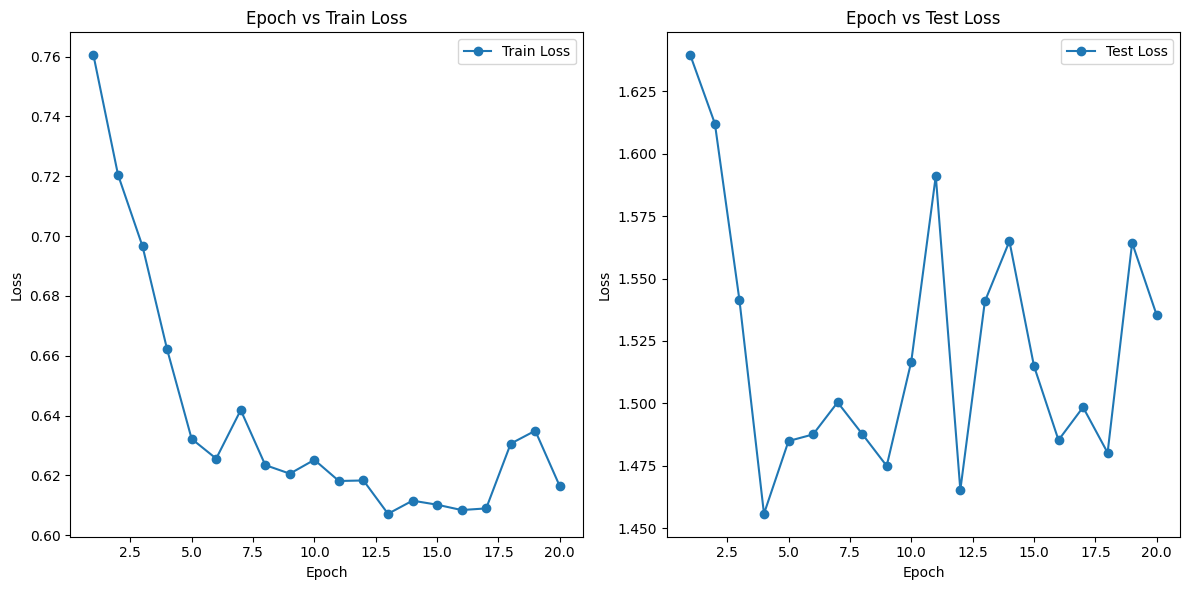

In [20]:
# Example data
epochs_range = range(1, len(train_losses) + 1)  # Assuming train_losses and test_losses have data

# Plot train loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Train Loss')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Retrieve mean and std values for inputs and targets
input_means = [scaler.mean_ for scaler in full_dataset.input_scalers]
input_stds = [scaler.scale_ for scaler in full_dataset.input_scalers]

target_means = [scaler.mean_ for scaler in full_dataset.target_scalers]
target_stds = [scaler.scale_ for scaler in full_dataset.target_scalers]

def destandardize(data, mean, std):
    """Reverse the standardization process."""
    return data * std + mean

# Convert lists to numpy arrays for easier manipulation
train_op_1 = np.array(train_op_1)
train_op_2 = np.array(train_op_2)
test_op_1 = np.array(test_op_1)
test_op_2 = np.array(test_op_2)

# Apply destandardization for train and test outputs
train_op_1_destandardized = destandardize(train_op_1, target_means[0], target_stds[0])
train_op_2_destandardized = destandardize(train_op_2, target_means[1], target_stds[1])

test_op_1_destandardized = destandardize(test_op_1, target_means[0], target_stds[0])
test_op_2_destandardized = destandardize(test_op_2, target_means[1], target_stds[1])

# Example print statements to verify results
print("Train Output 1 (Destandardized):", train_op_1_destandardized.shape)
print("Train Output 2 (Destandardized):", train_op_2_destandardized.shape)
print("Test Output 1 (Destandardized):", test_op_1_destandardized.shape)
print("Test Output 2 (Destandardized):", test_op_2_destandardized.shape)


Train Output 1 (Destandardized): (3840, 195)
Train Output 2 (Destandardized): (3840, 195)
Test Output 1 (Destandardized): (480, 195)
Test Output 2 (Destandardized): (480, 195)
